In [1]:
### Bibliotecas básicas de gestión de datos
import pandas as pd
import numpy as np

### Bibliotecas gráficas
import matplotlib.pyplot as plt
import seaborn as sns 

### Utilidades Scikit-learn 
from sklearn.model_selection import train_test_split

### Métricas
from sklearn import metrics
from sklearn.metrics import accuracy_score, roc_curve, auc

### Modelos
from xgboost import XGBClassifier, plot_importance

########################################################
### Para un flujo de trabajo más rápido, las bibliotecas de Interpretabilidad
### se instalarán/cargarán sobre la marcha del tutorial
########################################################

### Add-ons adicionales
import warnings
warnings.filterwarnings('ignore')
plt.style.use('fivethirtyeight')
%matplotlib inline

In [3]:
from sklearn import preprocessing
import pandas as pd
import numpy as np

#leemos archivo de pokemon
df = pd.read_csv("Datos/pokemon2.csv", nrows = 100000)
df_fights = pd.read_csv("Datos/combats.csv", nrows = 100000)

#Transformación de las columnas Type 1 y Type 2 con datos tipo String en columnas de tipos de pokemon con booleanos
types1 = pd.get_dummies(df["Type 1"])
types2 = pd.get_dummies(df["Type 2"])
pd.set_option('max_rows', None)
pd.reset_option('max_rows')
types = types1 | types2

df_clean = pd.merge(df, types, left_index=True, right_index=True)

df_clean.dropna(thresh=28,inplace=True)
df_clean.drop(["Type 1", "Type 2"], axis = 1,inplace= True)

# Se cambia el nombre de las columnas del dataframe de combates
df_fights.rename(columns = {'First_pokemon':'ID1', 'Second_pokemon':'ID2',
 'Winner': 'isFirstWinner'}, inplace = True)

#Se cambia el valor del la columna ganadora por un true o un false dependiendo de si ha ganado el pokemon de la primera columna o no
df_fights.loc[df_fights['isFirstWinner'] == df_fights['ID1'], 'isFirstWinner'] = True
df_fights.loc[df_fights['isFirstWinner'] == df_fights['ID2'], 'isFirstWinner'] = False
df_fights.dropna(inplace=True)

# Igualamos el nombre de la columna del id a ID1
df_clean.rename(columns = {'#':'ID1'}, inplace= True)

#Añadimos todos los campos del 1er pokemon a la tabla
df_fights = df_fights.merge(df_clean, on='ID1')

# Igualamos el nombre de la columna del id a ID2
df_clean.rename(columns = {'ID1':'ID2'}, inplace= True)
#Añadimos todos los campos del 2º pokemon a la tabla
df_fights = df_fights.merge(df_clean, on='ID2')

#El resultado de los ultimos dos merges es un dataframe cuyas columnas son
#los datos de dos pokemon en una misma linea y si el primero de ellos es el ganador del combate o no

df_fights = df_fights.drop(["ID1","ID2"], axis = 1)

#cambiamos true y false por ints 1 y 0 por comodidad
df_fights["isFirstWinner"] = df_fights["isFirstWinner"].astype(int)

df_scaled =df_fights.drop(["Name_x","Name_y"], axis=1)

df_scaled

,isFirstWinner,HP_x,Attack_x,Defense_x,Sp. Atk_x,Sp. Def_x,Speed_x,Generation_x,Legendary_x,Bug_x,...,Ghost_y,Grass_y,Ground_y,Ice_y,Normal_y,Poison_y,Psychic_y,Rock_y,Steel_y,Water_y
0,0,50,64,50,45,50,41,2,False,0,...,0,1,0,0,0,0,0,0,0,0
1,0,70,80,50,35,35,35,1,False,0,...,0,1,0,0,0,0,0,0,0,0
2,0,110,78,73,76,71,60,3,False,0,...,0,1,0,0,0,0,0,0,0,0
3,1,50,65,107,105,107,86,4,False,0,...,0,1,0,0,0,0,0,0,0,0
4,1,73,115,60,60,60,90,3,False,0,...,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,0,38,35,40,27,25,35,6,False,1,...,0,1,0,1,0,0,0,0,0,0
49996,1,55,45,50,45,65,80,2,False,0,...,0,1,0,1,0,0,0,0,0,0
49997,1,110,160,110,80,110,100,4,True,0,...,0,1,0,1,0,0,0,0,0,0
49998,1,104,91,63,91,73,68,3,False,0,...,0,1,0,1,0,0,0,0,0,0


<h2> Conjuntos de entrenamiento y test </h2>

In [10]:
X = df_scaled.iloc[:, 1:-1]
y = df_scaled.iloc[:, 0]
X

,HP_x,Attack_x,Defense_x,Sp. Atk_x,Sp. Def_x,Speed_x,Generation_x,Legendary_x,Bug_x,Dark_x,...,Flying_y,Ghost_y,Grass_y,Ground_y,Ice_y,Normal_y,Poison_y,Psychic_y,Rock_y,Steel_y
0,50,64,50,45,50,41,2,False,0,0,...,0,0,1,0,0,0,0,0,0,0
1,70,80,50,35,35,35,1,False,0,0,...,0,0,1,0,0,0,0,0,0,0
2,110,78,73,76,71,60,3,False,0,0,...,0,0,1,0,0,0,0,0,0,0
3,50,65,107,105,107,86,4,False,0,0,...,0,0,1,0,0,0,0,0,0,0
4,73,115,60,60,60,90,3,False,0,0,...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,38,35,40,27,25,35,6,False,1,0,...,0,0,1,0,1,0,0,0,0,0
49996,55,45,50,45,65,80,2,False,0,0,...,0,0,1,0,1,0,0,0,0,0
49997,110,160,110,80,110,100,4,True,0,0,...,0,0,1,0,1,0,0,0,0,0
49998,104,91,63,91,73,68,3,False,0,0,...,0,0,1,0,1,0,0,0,0,0


In [11]:
# Crear el objetivo y la columna de características y dividir el conjunto de datos en conjunto de prueba y de entrenamiento.



# 75% para entrenamiento, 25% para test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)
X_train.shape, X_test.shape

((37500, 51), (12500, 51))

<h2>Entrenar el modelo</h2>

In [12]:
%%time

# ML en dos líneas ;-)
# eval_metric = 'logloss' 
xgb = XGBClassifier(objective='binary:logistic', random_state=33, n_jobs=-1)
xgb.fit(X_train, y_train, eval_metric = 'logloss')

Wall time: 3.62 s


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=-1,
              num_parallel_tree=1, predictor='auto', random_state=33,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

<h2>Evaluación del rendimiento</h2>

In [13]:
# Realización de predicciones sobre los datos de las pruebas y evaluación del rendimiento
xgb_predictions = xgb.predict(X_test)
xgb_predictions

array([0, 0, 0, ..., 1, 0, 0])

In [14]:
# Diseñamos una función de evaluación de clasificación simple
def evaluation_scores(test, prediction, target_names=None):
    print('Precisión:', np.round(metrics.accuracy_score(test, prediction), 4)) 
    print('-'*60)
    print('Informe de clasificación:\n\n', metrics.classification_report(y_true=test, y_pred=prediction, target_names=target_names)) 
    
    classes = [0, 1]
    total_classes = len(classes)
    level_labels = [total_classes*[0], list(range(total_classes))]

    cm = metrics.confusion_matrix(y_true=test, y_pred=prediction, labels=classes)
#    cm_frame = pd.DataFrame(data=cm, columns=pd.MultiIndex(levels=[['Predicted:'], classes], labels=level_labels), index=pd.MultiIndex(levels=[['Actual:'], classes], labels=level_labels))    
    print('-'*60)
    print('Matriz de confusión:\n')
    print(cm) 

In [15]:
# Evaluamos las predicciones
evaluation_scores(y_test, xgb_predictions, target_names=['Pierde el primero', 'Gana el primero'])

Precisión: 0.9556
------------------------------------------------------------
Informe de clasificación:

                    precision    recall  f1-score   support

Pierde el primero       0.96      0.96      0.96      6581
  Gana el primero       0.95      0.95      0.95      5919

         accuracy                           0.96     12500
        macro avg       0.96      0.96      0.96     12500
     weighted avg       0.96      0.96      0.96     12500

------------------------------------------------------------
Matriz de confusión:

[[6315  266]
 [ 289 5630]]


<h2>Clasificación: ROC y AUC</h2>

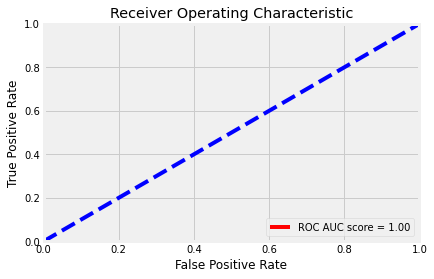

In [33]:
# calcular el FPR y el TPR para todos los umbrales de la clasificación
probs = xgb.predict_proba(X_test)
# Probabilidades positivas
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'red', label = 'ROC AUC score = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'b--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

<h2>Método de interpretabilidad</h2>

Text(0.5, 1.0, 'Importancia de las características con ganancia media')

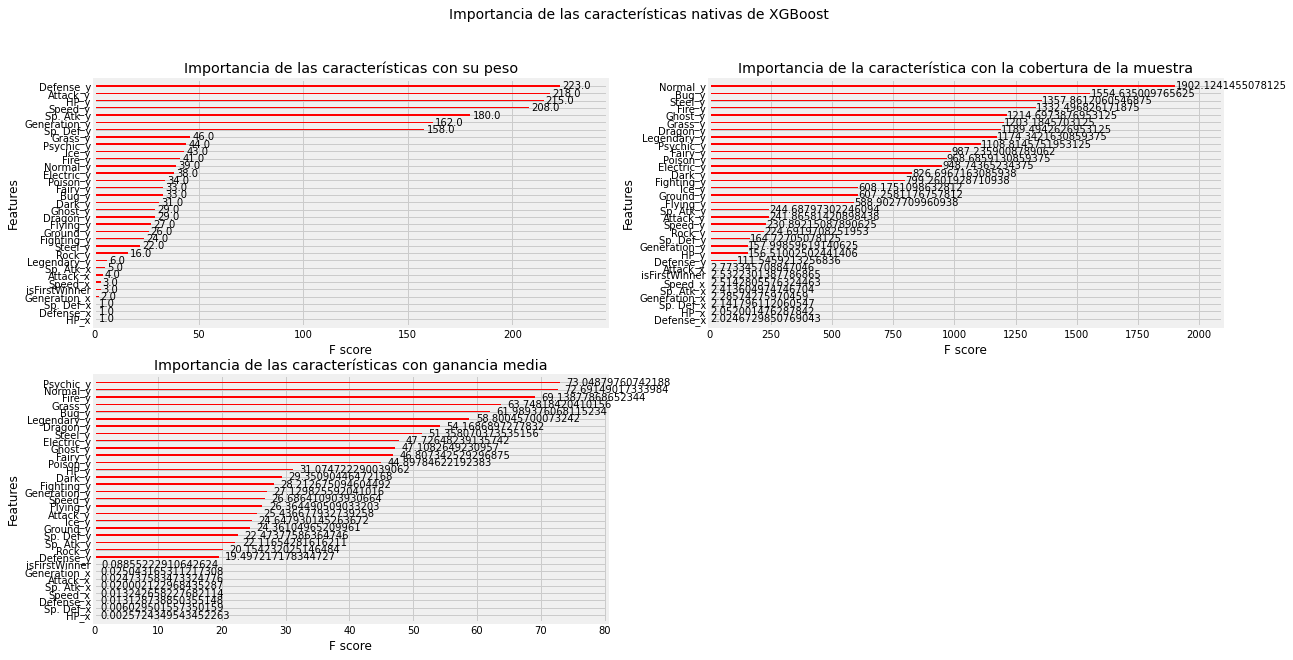

In [34]:
# Trazando la importancia de las características de XGBoost
fig = plt.figure(figsize = (18, 10))
title = fig.suptitle("Importancia de las características nativas de XGBoost", fontsize=14)

ax1 = fig.add_subplot(2, 2, 1)
plot_importance(xgb, importance_type='weight', ax=ax1, color='red')
ax1.set_title("Importancia de las características con su peso")

ax2 = fig.add_subplot(2, 2, 2)
plot_importance(xgb, importance_type='cover', ax=ax2, color='red')
ax2.set_title("Importancia de la característica con la cobertura de la muestra")

ax3 = fig.add_subplot(2, 2, 3)
plot_importance(xgb, importance_type='gain', ax=ax3, color='red')
ax3.set_title("Importancia de las características con ganancia media")

<h2>ELI5 Model Interpretation</h2>

In [ ]:
# pip install eli5
import eli5
from eli5.sklearn import PermutationImportance

In [ ]:
eli5.show_weights(xgb.get_booster())

In [ ]:
%%time

# necesitamos reentrenar un nuevo modelo con arrays
# ya que eli5 tiene un error con Dataframes y XGBoost
# cf. https://github.com/TeamHG-Memex/eli5/pull/261
xgb_array = XGBClassifier(objective='binary:logistic', random_state=33, n_jobs=-1)
xgb_array.fit(X_train, y_train, eval_metric = 'logloss')

In [ ]:
feat_permut = PermutationImportance(xgb_array, random_state=33).fit(X_train, y_train)
eli5.show_weights(feat_permut, feature_names = features_list)

In [ ]:
# pip install pdpbox
from pdpbox import pdp, get_dataset, info_plots